In [8]:
import Master
import prod4a_merge_study
import Plots

import awkward as ak
import numpy as np
import pandas as pd

#* check signal/background purity/efficiency per event
#* gauge number of events where merging occured/was good

# shower_quantities = prod4a_merge_study.ShowerMergeQuantities(analysedCuts="csv/cuts/analysedCuts-6GeV.csv")
# shower_quantities.bestCut = "purity"
# shower_quantities.LoadQuantitiesToCSV("csv/merge-quantities/merge-quantities-6GeV.csv")
data = pd.read_csv("csv/merge-quantities/merge-quantities-6GeV.csv")

print(data.head)

cuts = pd.read_csv("csv/cuts/analysedCuts-6GeV.csv")
cut = prod4a_merge_study.BestCut(cuts, cuts.columns, "purity")

selectionVariables = [
    "alpha",    
    "delta_x",
    "delta_xl",
    "delta_xt",
    "delta_phi",
    "d",
    "t",
    "p",
]

print(cuts.columns)

for i in range(len(selectionVariables)):
    v = cuts[selectionVariables[i]][cut[0]]
    if i == 0:
        mask = data[selectionVariables[i]].values < v
    else:
        mask = np.logical_and(mask, data[selectionVariables[i]].values < v)



<bound method NDFrame.head of          entry  subentry  subsubentry     alpha     delta_x    delta_xl  \
0            0         0            0  2.131110  312.926331  166.305314   
1            0         0            1  0.977984  183.587274  102.569433   
2            0         0            2  1.891957  335.998907  106.064166   
3            0         0            3  1.990120  344.502990  140.261980   
4            0         0            4  1.817585  333.437917   81.455788   
...        ...       ...          ...       ...         ...         ...   
1993209      1      4355          338  2.167516  399.498697  224.491079   
1993210      1      4355          339  2.778371  113.064925  105.688250   
1993211      1      4355          340  1.987625  301.706045  122.149424   
1993212      1      4355          341  2.005819  399.684766  168.439454   
1993213      1      4355          342  2.512545  396.709371  320.774461   

           delta_xt  delta_phi           d           t           p  s

In [9]:
def Format(e : ak.Array, se : ak.Array, s : ak.Array, b : ak.Array, m : ak.Array = None):
    """ nest data

    Args:
        e (ak.Array): entries
        se (ak.Array): subentries
        s (ak.Array): signal
        b (ak.Array): background

    Returns:
        tuple: nested signal and background
    """
    nentry = np.unique(e, return_counts=True)
    sub = ak.unflatten(se, nentry[1])
    sig = ak.unflatten(s, nentry[1])
    back = ak.unflatten(b, nentry[1])
    if m is not None:
        mask = ak.unflatten(m, nentry[1])

    nsub = [np.unique(sub[i], return_counts=True)[1] for i in range(len(nentry[0]))]
    sig = [ak.unflatten(sig[i], nsub[i]) for i in range(len(nentry[0]))]
    back = [ak.unflatten(back[i], nsub[i]) for i in range(len(nentry[0]))]
    if m is not None:
        m = [ak.unflatten(mask[i], nsub[i]) for i in range(len(nentry[0]))]
        return sig, back, m
    else:
        return sig, back

entry = ak.Array(data["entry"].values)
sub = ak.Array(data["subentry"].values)
subsub = ak.Array(data["subsubentry"].values)
s = ak.Array(data["signal"].values)
b = ak.Array(data["background"].values)

s, b, mask = Format(entry, sub, s, b, mask)

total number of events: 4356
Number of events where merging can be performed:3334
Number of events where merging is performed:1802
number of events with a false postive: 1003


/home/sb16165/anaconda3/envs/python3_6_8/lib/python3.6/site-packages/awkward/_connect/_numpy.py:210: RuntimeWarning: invalid value encountered in true_divide
  *[nplike.asarray(x) for x in inputs], **kwargs


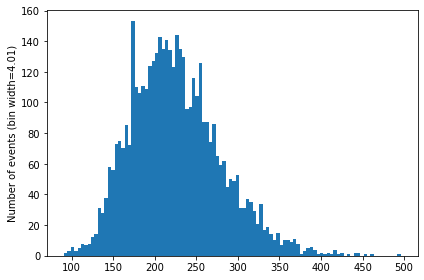

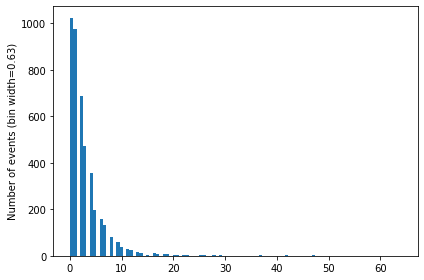

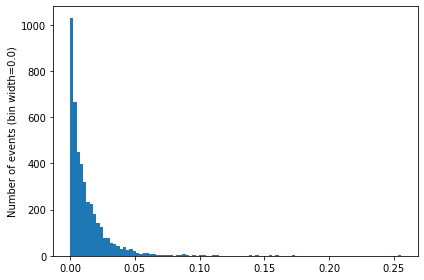

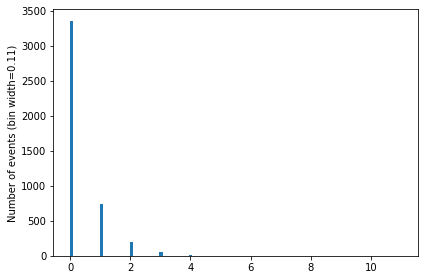

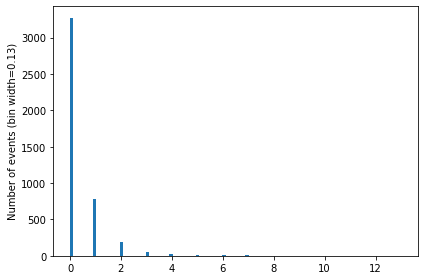

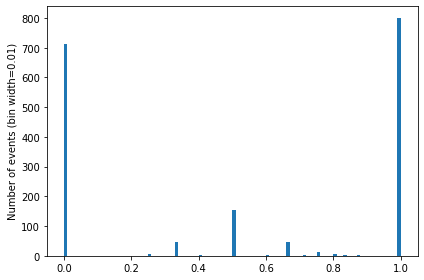

In [23]:
def Plot(s, b):
    n_s = ak.count(s[s], -1)
    n_b = ak.count(b[b], -1)
    p = n_s / (n_s + n_b)

    Plots.PlotHist(n_b)
    Plots.PlotHist(n_s)
    Plots.PlotHist(p)


s_all = np.logical_or(*s)
b_all = np.logical_or(*b)
m_all = np.logical_or(*mask)

print(f"total number of events: {ak.count(s_all, 0)[0]}")

to_improve = ak.count(s_all[s_all], -1) > 0
to_improve = ak.count(to_improve[to_improve])
print(f"Number of events where merging can be performed:{to_improve}")

actually_improve = (ak.count(s_all[m_all][s_all[m_all]], -1) + ak.count(b_all[m_all][b_all[m_all]], -1)) > 0
actually_improve = ak.count(actually_improve[actually_improve])
print(f"Number of events where merging is performed:{actually_improve}")

false_positive = ak.count(b_all[m_all][b_all[m_all]], -1) > 0
false_positive = ak.count(false_positive[false_positive])
print(f"number of events with a false postive: {false_positive}")

Plot(s_all, b_all)
Plot(s_all[m_all], b_all[m_all])

In [1]:
import Master
import vector
import awkward as ak
import numpy as np
from tabulate import tabulate
import Plots
from prod4a_merge_study import EventSelection, ShowerMergeQuantities, BestCut
import itertools
import pandas as pd

nEvents = 500
events = Master.Data("work/ROOTFiles/Prod4a_6GeV_BeamSim_00.root", True)#, _nEvents=nEvents)
cuts = "csv/cuts/analysedCuts-6GeV.csv"

start_showers = EventSelection(events)
mask = np.logical_or(events.recoParticles.cnnScore > 0.64, np.logical_or(*start_showers)) # select PFOs which pass CNN selection or are start showers
events.Filter([mask])
start_showers = [start_showers[i][mask] for i in range(2)]
to_merge = np.logical_not(np.logical_or(*start_showers))

quantities = ShowerMergeQuantities(events, to_merge, cuts)

n_merge = -1

print("calculating score...")
def SortByStartingShower(data):
    data = [ak.unflatten(data[i], 1, -1) for i in range(2)]
    return ak.concatenate(data, -1)

def ClosestQuantity(q : ak.Array, mask : ak.Array):
    masked_q = ak.where(mask, q, 9999999)
    q_to_merge = ak.argmin(masked_q, -1, keepdims=True)
    return ak.where(ak.min(masked_q, -1, keepdims=True) == 9999999, -1, q_to_merge)

#* retrieve quantities and find which start shower is closest to each PFO for each variable
quantities.Evaluate(events, start_showers)
print("evaluated quantities")
mask = SortByStartingShower(quantities.mask) # PFOs we want to merge after cut based study is done
alpha = ClosestQuantity(SortByStartingShower(quantities.alpha), mask) # can use this to determine which starting shower the PFO is closest to in angle
x = ClosestQuantity(SortByStartingShower(quantities.delta_x), mask) # can use this to determine which starting shower the PFO is closest to in space
phi = ClosestQuantity(SortByStartingShower(quantities.delta_phi), mask) # can use this to determine which starting shower the PFO direction is most aligned to
print(mask)

#* figure out which is the common start shower between all variables
# if min phi, alpha and x are all the same then merge to that shower
# if two are the same, merge to the most common shower
# if none agree (shouldn't be possible)
#! should replace this with calculating the mode of the scores
scores_raw = ak.sum(ak.concatenate([phi, x, alpha], -1), -1)
scores = ak.where(scores_raw == 1, 0, scores_raw) # [1, 0, 0]
scores = ak.where(scores_raw == 2, 1, scores_raw) # [1, 1, 0]
scores = ak.where(scores_raw == 3, 1, scores_raw) # [1, 1, 1]

/home/sb16165/Documents/pi0-analysis/analysis/Master.py:50: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/Master.py:50: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/Master.py:50: UserWarning: Couldn't apply filters to _TrueParticleData__pi0_MC.
  warnings.warn(f"Couldn't apply filters to {var}.")


'BeamMCFilter' executed in 11.3045s
number of dalitz decays: 222
'ApplyBeamFilter' executed in 7.3684s
\begin{tabular}{lllll}
\hline
 event selection                   & type        & number of events & percentage of events removed & percentage of events remaining \\
 no selection                      & -           & 100222           & -                            &                                \\
 beam -\ensuremath{>} pi0 + X                   & truth       & 27341            & 72.71956257109217            & 100                            \\
 pi+ beam                          & backtracked & 19949            & 27.036319081233312           & 72.96368091876668              \\
 diphoton decay                    & truth       & 19727            & 1.1128377362273798           & 72.15171354376211              \\
 beam particle                     & reco        & 10017            & 49.22187864348355            & 36.637284664057646             \\
 nPFP \ensuremath{>} 1                      

/home/sb16165/Documents/pi0-analysis/analysis/Master.py:50: UserWarning: Couldn't apply filters to _RecoParticleData__beam_number.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/Master.py:50: UserWarning: Couldn't apply filters to _RecoParticleData__beamVertex.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/Master.py:50: UserWarning: Couldn't apply filters to run.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/Master.py:50: UserWarning: Couldn't apply filters to subRun.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/Master.py:50: UserWarning: Couldn't apply filters to eventNum.
  warnings.warn(f"Couldn't apply filters to {var}.")


calculating score...
finding best cut
Best cut: 
|       |   Unnamed: 0 |   alpha |   delta_x |   delta_xl |   delta_xt |   delta_phi |      d |       t |       p |    s |    b |      s/b |   $s\sqrt{b}$ |   purity |   $\epsilon_{s}$ |   $\epsilon_{b}$ |   $\epsilon$ |
|------:|-------------:|--------:|----------:|-----------:|-----------:|------------:|-------:|--------:|--------:|-----:|-----:|---------:|--------------:|---------:|-----------------:|-----------------:|-------------:|
| 19675 |        19675 | 1.56984 |   154.936 |    587.298 |    17.3581 |     1.57073 | 119.92 | 143.179 | 1002.27 | 1385 | 1419 | 0.976039 |        36.767 | 0.493937 |         0.105596 |       0.00072141 |   0.00141609 |
'Evaluate' executed in 255.7061s
evaluated quantities
[[[False, False], [False, False], [False, ... [False, False], [False, False]]]


In [5]:
def ShowerMergingPFOPerformance(start_showers, to_merge, scores, quantities):
    # false negative - showers we should have merged but didn't
    # false positive - showers we merged but shouldn't have
    # true positive - showers we should have merged and did
    # true negative - showers we should have merged but didn't
    # mismatch - of the showers merged, which were assigned to the wrong start shower

    all_showers = np.logical_or(*start_showers)
    s_num = events.trueParticlesBT.number[all_showers]
    tm_num = events.trueParticlesBT.number[to_merge]

    signals = [s_num[:, i] == tm_num for i in range(2)]
    signal_all = np.logical_or(*signals)[quantities.null] # showers we should have merged
    background = np.logical_not(signal_all) # showers we shouldn't have merged

    merged = scores != -3 # PFOs actually merged
    not_merged = np.logical_not(merged)

    print(ak.count(merged))
    print(ak.count(signal_all))

    tp = np.logical_and(merged, signal_all) # true positive, signal pfos merged
    tn = np.logical_not(np.logical_or(merged, signal_all)) # true negative, background not merged

    xor = np.logical_xor(merged, signal_all)

    fp = np.logical_and(xor, signal_all == False) # false positive, background PFOs merged
    fn = np.logical_and(xor, signal_all == True) # false negative, signal PFOs not merged

    nSignal = ak.count(signal_all[signal_all])
    nBackground = ak.count(background[background])
    nMerged = ak.count(merged[merged])
    nUnmerged = ak.count(not_merged[not_merged])

    print(f"number of signal PFOs before cutting: {nSignal}")
    print(f"number of background PFOs before cutting: {nBackground}")
    confusion = [
        ["performance metric", "number of PFOs", "percentage (signal/background)", "percentage (merged, unmerged)"],
        ["signal PFOs merged (true positives)", ak.count(tp[tp]), 100 * ak.count(tp[tp])/nSignal, 100 * ak.count(tp[tp])/nMerged],
        ["background PFOs merged (false positive)", ak.count(fp[fp]), 100 * ak.count(fp[fp])/nBackground, 100 * ak.count(fp[fp])/nMerged],
        ["signal PFOs not merged (false negative)", ak.count(fn[fn]), 100 * ak.count(fn[fn])/nSignal, 100 * ak.count(fn[fn])/nUnmerged],
        ["background PFOs not merged (true negatives)", ak.count(tn[tn]), 100 * ak.count(tn[tn])/nBackground, 100 * ak.count(tn[tn])/nUnmerged]
        ]

    print(f"scores: {ak.count(scores)}")
    print(f"to_merge: {ak.count(events.trueParticlesBT.number)}")

    signal_num = events.trueParticlesBT.number[to_merge][quantities.null][signal_all]
    target_num = events.trueParticlesBT.number[to_merge][quantities.null][tp]
    actual_num = ak.where(scores == 0, s_num[:, 0], scores)
    actual_num = ak.where(actual_num == 1, s_num[:, 1], actual_num)
    actual_num = actual_num[tp]

    actual_num = actual_num[ak.num(actual_num) > 0]
    target_num = target_num[ak.num(target_num) > 0]

    mismatch = ak.ravel(actual_num == target_num)
    print(f"mismatch (%): {100 * ak.count(mismatch[mismatch == False]) / ak.count(mismatch)}")

    print(tabulate(confusion, floatfmt=".2f", tablefmt="fancy_grid"))

    mask = quantities.mask
    cut_signal = signal_all[np.logical_or(*mask)]
    print(ak.count(ak.ravel(cut_signal[cut_signal])))
    globals().update(locals()) #! debugging only!

ShowerMergingPFOPerformance(start_showers, to_merge, scores, quantities)

996607
996607
number of signal PFOs before cutting: 13116
number of background PFOs before cutting: 983491
scores: 996607
to_merge: 1026551
mismatch (%): 24.431486880466473
╒═════════════════════════════════════════════╤════════════════╤════════════════════════════════╤═══════════════════════════════╕
│ performance metric                          │ number of PFOs │ percentage (signal/background) │ percentage (merged, unmerged) │
├─────────────────────────────────────────────┼────────────────┼────────────────────────────────┼───────────────────────────────┤
│ signal PFOs merged (true positives)         │ 1715           │ 13.075632814882587             │ 55.44778532169415             │
├─────────────────────────────────────────────┼────────────────┼────────────────────────────────┼───────────────────────────────┤
│ background PFOs merged (false positive)     │ 1378           │ 0.14011312762394368            │ 44.55221467830585             │
├─────────────────────────────────────────────┼

In [7]:
def ShowerMergingEventPerformance(start_showers, to_merge, scores, quantities):
    all_showers = np.logical_or(*start_showers)
    s_num = events.trueParticlesBT.number[all_showers]
    tm_num = events.trueParticlesBT.number[to_merge]

    signal = np.logical_or(*[tm_num == s_num[:, i] for i in range(2)])[quantities.null] # showers we should have merged
    background = np.logical_not(signal) # showers we shouldn't have merged

    merged = scores != -3 # PFOs actually merged
    not_merged = np.logical_not(merged)

    nMerged = ak.count(merged[merged], -1)
    nSignal = ak.count(signal[signal], -1)
    nBackground = ak.count(background[background], -1)

    tp = np.logical_and(merged, signal) # true positive
    nTp = ak.count(tp[tp], -1)

    xor = np.logical_xor(merged, signal)

    fp = np.logical_and(xor, signal == False) # false positive
    nFp = ak.count(fp[fp], -1)
    t = np.logical_and(nFp > 0, nTp > 0)

    signal_only = np.logical_and(nFp == 0, nTp > 0)
    background_only = np.logical_and(nFp > 0, nTp == 0)

    print(nMerged)
    print(nSignal)
    print(nBackground)
    print(f"number of events: {ak.count(events.eventNum)}")
    print(f"number of events with PFOs to merge: {ak.count(nSignal[nSignal > 0])}")
    print(f"number of events where we merge: {ak.count(nMerged[nMerged > 0])}")
    print(f"number of events where we merge signal: {ak.count(nTp[nTp > 0])}")
    print(f"number of events where we merge background: {ak.count(nFp[nFp > 0])}")
    print(f"number of events where we merge signal and background {ak.count(t[t])}")
    print(f"number of events where we merge only signal {ak.count(signal_only[signal_only])}")
    print(f"number of events where we merge only background {ak.count(background_only[background_only])}")

ShowerMergingEventPerformance(start_showers, to_merge, scores, quantities)

[0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 1, 1, 0, 0, ... 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 1, 3, 2]
[2, 1, 0, 4, 0, 0, 0, 0, 2, 0, 2, 7, 0, ... 1, 2, 0, 2, 1, 6, 3, 20, 0, 1, 5, 7, 18]
[300, 220, 159, 161, 165, 224, 137, 270, ... 228, 306, 155, 182, 185, 288, 271, 325]
number of events: 4356
number of events with PFOs to merge: 3334
number of events where we merge: 1802
number of events where we merge signal: 1089
number of events where we merge background: 1003
number of events where we merge signal and background 290
number of events where we merge only signal 799
number of events where we merge only background 713
